In [1]:
import json
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from math import sqrt
import os
from os import listdir
import re
import bisect
import random
# import pickle
from sklearn.metrics import mean_squared_error
import heapq
import matplotlib.pyplot as plt
import time
import argparse
import tensorflow as tf
from Model_General import Model
from tqdm import tqdm

import pickle5
import pandas as pd
from anytree import Node, RenderTree,NodeMixin
import heapq
import re
from matplotlib.pyplot import hist
from ngram_fusion_util import *
from ProactiveUtil import *
from utilgeneral import *

C:\Users\lilee\anaconda3new\envs\temporal_3_6python\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\lilee\anaconda3new\envs\temporal_3_6python\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\lilee\anaconda3new\envs\temporal_3_6python\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\lilee\anaconda3n

In [2]:
print(tf. __version__)

1.12.0


In [3]:
#load model

parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='Mapping_Result_ExceptTVseries_i3u3_1000000',type=str)
parser.add_argument('--train_dir', default='default',type=str)
parser.add_argument('--batch_size', default=128, type=int)
parser.add_argument('--lr', default=0.001, type=float)
parser.add_argument('--maxlen', default=53, type=int)
parser.add_argument('--hidden_units', default=50, type=int)
parser.add_argument('--num_blocks', default=2, type=int)
parser.add_argument('--num_epochs', default=101, type=int)
parser.add_argument('--num_heads', default=1, type=int)
parser.add_argument('--time_span', default=18000, type=int)
parser.add_argument('--dropout_rate', default=0.2, type=float)
parser.add_argument('--l2_emb', default=0.00005, type=float)
parser.add_argument('-f')
args = parser.parse_args()

if not os.path.isdir(args.dataset + '_' + args.train_dir):
    os.makedirs(args.dataset + '_' + args.train_dir)
with open(os.path.join(args.dataset + '_' + args.train_dir, 'args.txt'), 'w') as f:
    f.write('\n'.join([str(k) + ',' + str(v) for k, v in sorted(vars(args).items(), key=lambda x: x[0])]))
f.close()

# dataset = data_partition_daysplit_doubletime(args.dataset,1900283)
dataset = data_partition_daysplit_doubletime(args.dataset,0.5)
# [user_train, user_valid, user_test, usernum, itemnum, timenum] = dataset
[user_train, user_test, usernum, itemnum, timenum] = dataset
print('User: %d, Item: %d:, Timenum: %d'%(usernum, itemnum, timenum))
num_batch = int(len(user_train) / args.batch_size)
cc = 0.0
for u in user_train:
    cc += len(user_train[u])
print('average sequence length: %.2f' % (cc / len(user_train)))

Preparing double time data...
time min 21.0
time min 21.0
saved mapped user time map parameters
max time 1900794.0000000002
using util general Preparing done... timenum and ratio 1900773 0.5
User: 23127, Item: 13582:, Timenum: 1900773
average sequence length: 5.17


In [4]:
model = Model(usernum, itemnum, timenum,args)
savernew = tf.train.Saver()
sess = tf.Session()
savernew.restore(sess, 'model/Modeliptvi3u3span18000len53-model.ckpt')

INFO:tensorflow:Restoring parameters from model/Modeliptvi3u3span18000len53-model.ckpt


In [5]:
treepath = '../../data/iptvdata/'
tree_file = 'NgramiptvExceptTVseries_i3u3_sample1000000N3.pkl'
with open(treepath+tree_file, 'rb') as input:
    treeroot = pickle5.load(input)

In [6]:
#the following is loading testing dataset
filepath = '../../data/iptvdata/'
filename = 'iptv_sample1000000.csv'
df = pd.read_csv(filepath+filename)
df = df.sort_values(by=['time'],ascending = (True))
df

,time,user,item
921772,2010-06-23 23:59:59,00111010001000111010010101100110,棒球大联盟第3季(第12集).mp4
170271,2010-06-24 00:00:00,00111010000100000100001100100110,棒球大联盟第1季(第26集).mp4
897261,2010-06-24 00:00:01,00111010001000110111111111010101,泡沫之夏(第03集).mp4
834023,2010-06-24 00:00:04,00111010001000110000111001011110,AIR(第01集).mp4
803235,2010-06-24 00:00:05,00111010001000101100101101111010,重案六组3(第01集).mp4
...,...,...,...
334475,2010-07-15 23:59:56,00111010000100001111000110111010,半路兄弟(第04集).mp4
668088,2010-07-15 23:59:56,00111010001000011000001001011000,樱桃小丸子(第01集).mp4
41302,2010-07-15 23:59:57,00111010000100000000001010000100,反抗之真心英雄(第25集).mp4
109893,2010-07-15 23:59:59,00111010000100000001110100111111,暮色3：月食(抢先版).mp4


In [7]:
#dataset parameter:
dataset_begintime = datetime(2010,6,24)
ratio = 0.5
df['time'] = pd.to_datetime(df['time'])
splittime = dataset_begintime + (df['time'].max()- dataset_begintime)*ratio
df_test = df[df['time']>splittime]
df_test

,time,user,item
262481,2010-07-05 00:00:00,00111010000100001011011101010111,宫心计国语版(第16集).mp4
591458,2010-07-05 00:00:00,00111010001000010000001110010111,加油!网球王子(第01集).mp4
982004,2010-07-05 00:00:02,00111010001001010000110000001011,无法阻挡的婚姻.mp4
269294,2010-07-05 00:00:02,00111010000100001011111001100101,马英九为后ECFA时代台湾经济战略定调-7月3日.mp4
663543,2010-07-05 00:00:03,00111010001000010111100110110110,风云雄霸天下(蓝光).mp4
...,...,...,...
334475,2010-07-15 23:59:56,00111010000100001111000110111010,半路兄弟(第04集).mp4
668088,2010-07-15 23:59:56,00111010001000011000001001011000,樱桃小丸子(第01集).mp4
41302,2010-07-15 23:59:57,00111010000100000000001010000100,反抗之真心英雄(第25集).mp4
109893,2010-07-15 23:59:59,00111010000100000001110100111111,暮色3：月食(抢先版).mp4


In [8]:
df_test.dropna(inplace=True)
# np.nan in list(['item'])
df_test
df_test.to_csv(filepath+'iptv_sample1000000testing.csv')

C:\Users\lilee\anaconda3new\envs\temporal_3_6python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
#the following is loading mapping result
itemmappingfilename = 'Item_Mapping_ExceptTVseries_i3u3_1000000.txt'
usermappingfilename = 'User_Mapping_ExceptTVseries_i3u3_1000000.txt'
itemmapping = pd.read_csv(filepath+itemmappingfilename,sep='\t',names=['itemname','num'])
usermapping = pd.read_csv(filepath+usermappingfilename,sep='\t',names=['username','num'])
usermappingdict = defaultdict(int)
itemmappingdict = defaultdict(int)
for index,user in usermapping.iterrows():
    username = user[0]
    userencode = user[1]
    usermappingdict[username] = userencode
    usermappingdict[userencode] = username
for index,item in itemmapping.iterrows():
    itemname = str(item[0])
    itemencode = item[1]
    itemmappingdict[itemname] = itemencode
    itemmappingdict[itemencode] = itemname



In [10]:
#the followng is loading medium and std for each item
medium_std_filename = '0to11days_iptv_median_std.txt'
medium_std = pd.read_csv(filepath+medium_std_filename,sep='\t',names=['item','medium','std'])

(array([13., 11.,  8.,  7.,  8.,  4.,  6.,  0.,  0.,  0.]),
 array([100., 110., 120., 130., 140., 150., 160., 170., 180., 190., 200.]),
 <BarContainer object of 10 artists>)

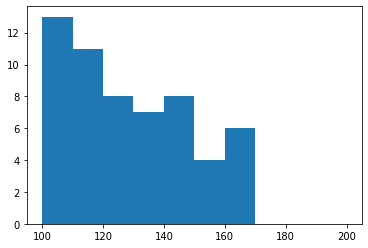

In [11]:
plt.hist(medium_std['medium'],range=(100,200))

In [12]:
medium_std_dict = defaultdict(list)
for index,item in medium_std.iterrows():
#     print(item[0],item[1],item[2],item[1:])
#     w
    medium_std_dict[item[0]] = [item[1],item[2]]


In [13]:
# medium_std_dict['绯闻少女第3季第17集(预告片).mp4'][0] > 0

In [14]:
def isseries(item):
    if len(item.split('(第')) >= 2 and len(item.split('(第')[1].split('集)')) >= 2 and item.split('(第')[1].split('集)')[0].isdigit():
        return True
    elif len(item)>3 and item[-1].isdigit() and not item[-4].isdigit() and item[-3]!='/' and item[-3]!=':' and item[-3:]!='mp4' and len(re.findall(r"\d+", item[-3:]))>0:
        return True
    else:
        return False

In [15]:
def predict_next_series(item):
    if len(item.split('(第')) >= 2 and len(item.split('(第')[1].split('集)')) >= 2 and item.split('(第')[1].split('集)')[0].isdigit():
        episode_num = item.split('(第')[1].split('集)')[0]
        predicted_series_item = item.split('(第')[0]+'(第'+re.sub(episode_num, str(int(episode_num)+1).zfill(len(episode_num)), episode_num)+'集)'+item.split('集)')[1]
        return predicted_series_item
    elif len(item)>3 and item[-1].isdigit() and not item[-4].isdigit() and item[-3]!='/' and item[-3]!=':' and item[-3:]!='mp4' and len(re.findall(r"\d+", item[-3:]))>0:
        episode_num = re.findall(r"\d+", item[-3:])[0]
        predicted_series_item = item[:-3]+re.sub(episode_num, str(int(episode_num)+1).zfill(len(episode_num)), item[-3:])
        return predicted_series_item
    else:
        return item

In [16]:
# from ProactiveUtil import *

In [17]:
def PEC(CACHE_SIZE = 100, ratio = 0.9, lruN = 2,downloadtime = 0.5,printoutfrequency = 1000,begintime = datetime(2010,7,5), stop_time = datetime(2010,7,5,1)):
    #the followsing is caching simulator
#     CACHE_SIZE = 1000
#     begintime = datetime(2010,7,5)
    P_CACHE_SIZE = int(CACHE_SIZE*ratio)
    R_CACHE_SIZE= CACHE_SIZE  - P_CACHE_SIZE
#     downloadtime = 0.5
#     printoutfrequency = 1000
#     stop_point = 10000  
    clear_point = 1000
    count = 0
    total_count = 0
    ngram_dict = {}
    ngram_dict_time = {}
    ngram_dict_confidence = {}
    N = 2 #N+1 gram
#     lruN = 8
    fusiontopk = 10
    preditivemodeltopk = 20
    guess_len = 20
    SCORE_Norm = 10
    total_count = 0
    local_count = 0
    proactive_cache = set()
    reactive_cache = set()
    hit = 0
    accum_hit = 0
    soft_hit = 0
    proactive_download = 0
    reactive_download_number = 0
    hit_rate_list = []
    Series_len = {}
    Cache_score = {}
    Prediction_score_dict = {}
    Reactive_item_proactive_score = {}
    user_contribution2item = {}
    past_timestamps = {}
    reactive_latency = 0
    proactive_latency = 0
    proactive_download_list = []
    utilization_list_proactive = []
    utilization_list_reactive = []
    utilization_list_all = []
    calculatetime = begintime

    watch_ratio_est_list = []
    watch_ratio_gt_list = []
    we_have_nan = False


    count_tvseries = 0
    count_activeother = 0
    count_other = 0
    last_time = datetime.now()
    updatetime = begintime
    
    updating_time_overhead_list = []
    prediction_time_overhead_list = []

#     updating_time_overhead_list = []
    
    bandwidth_link = {'begin time':[],'end time':[],'item':[],'proactive_indicator':[]}
    print('p cache size:',P_CACHE_SIZE,'r cache size:',R_CACHE_SIZE,'frequency',printoutfrequency,'downloadtime',downloadtime,'lruN',lruN)
    print('begintime',begintime,'stoptime',stop_time)

    for index, row in df_test.iterrows():
        user = row[1]
        time = row[0].to_pydatetime()#avoid <class 'pandas._libs.tslibs.timestamps.Timestamp'>, we need datetime
    #     time = datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S')
        item = row[2]
    #     if len(item.split('(第'))>=2:
    # #         print(item)
    #         pass
    #     else:
    #         continue
        if time < begintime:
            continue


        if total_count == 0:
            link_empty_time = time
        total_count += 1
        
#         if total_count < 30000:
#             continue
            
        local_count += 1
        if item not in Prediction_score_dict and item not in Cache_score and item not in Reactive_item_proactive_score:
            Prediction_score_dict[item] = []
    #update link
        if time>updatetime:
            updatebegintime = datetime.now()
            update_predition_from_time(Prediction_score_dict,time,user_contribution2item)#use this score to do proactive caching
            update_predition_from_time(Cache_score, time,user_contribution2item)  # use this score to do proactive caching
            update_predition_from_time(Reactive_item_proactive_score,time,user_contribution2item)  # use this score to maintain proactive score
            updatetime += timedelta(minutes=1)
            updating_time_overhead_list.append((datetime.now()-updatebegintime).total_seconds())

    #update link from last time to current time, so we can not update score on current time t, update_predition_from_time(Cache_score, time,user_contribution2item)
        for i in range(len(bandwidth_link['item'])):

            if bandwidth_link['end time'][0] < time:
                req_time = bandwidth_link['begin time'].pop(0)
                downloaoded_time = bandwidth_link['end time'].pop(0)
                downloaded_item = bandwidth_link['item'].pop(0)                
                proactive_indicator = bandwidth_link['proactive_indicator'].pop(0)
                if downloaded_item == 'nan':
                    print(downloaded_item,bandwidth_link,req_time,downloaded_item,proactive_indicator)
#actually we do not need keey the score the latest for cache updating, we just user current score is ok, because we only care about current cache state
#                 update_predition_from_time(Prediction_score_dict,downloaoded_time,user_contribution2item)  # use this score to do proactive caching
#                 update_predition_from_time(Cache_score, downloaoded_time,user_contribution2item)  # use this score to do proactive caching

                downloaded_item_score = check_score(Prediction_score_dict, downloaded_item,downloaoded_time)


                #proactive and reactive cache
                if proactive_indicator is True:
#                     proactive_download += 1
                    #go to proactive cache
                    if len(proactive_cache) < P_CACHE_SIZE:
                        # add item to cache
                        proactive_cache.add(downloaded_item)
                        record = Prediction_score_dict[downloaded_item]
                        Cache_score[downloaded_item] = record
                        del Prediction_score_dict[downloaded_item]
                    elif downloaded_item not in proactive_cache and downloaded_item not in reactive_cache:
                        # update cache
                        lowest_item, lowest_score = get_lowest_content(Cache_score, downloaoded_time)
                        if compare_score(downloaded_item_score, lowest_score):
                            proactive_cache.add(downloaded_item)
                            record = Prediction_score_dict[downloaded_item]
                            Cache_score[downloaded_item] = record
                            del Prediction_score_dict[downloaded_item]
                            if len(proactive_cache) > P_CACHE_SIZE:
                                proactive_cache.remove(lowest_item)
                                record = Cache_score[lowest_item]
                                Prediction_score_dict[lowest_item] = record
                                del Cache_score[lowest_item]
                    else:
                        #hit
                        pass


                else:
#                     reactive_download_number += 1
                    #go to reactive cache
                    if len(reactive_cache) < R_CACHE_SIZE:
                        #add item to cache
                        reactive_cache.add(downloaded_item)
                        record = Prediction_score_dict[downloaded_item]
                        Reactive_item_proactive_score[downloaded_item] = record
                        del Prediction_score_dict[downloaded_item]
                    elif downloaded_item not in reactive_cache and downloaded_item not in proactive_cache:
                        #update reactive cache
                        reactive_cache.add(downloaded_item)
                        record = Prediction_score_dict[downloaded_item]
                        Reactive_item_proactive_score[downloaded_item] = record
                        del Prediction_score_dict[downloaded_item]


                        position, kick_name, pasttimeforrank = get_lruK_action_rank(lruN, reactive_cache, past_timestamps,time)
                        reactive_cache.remove(kick_name)
                        record = Reactive_item_proactive_score[kick_name]
                        Prediction_score_dict[kick_name] = record
                        del Reactive_item_proactive_score[kick_name]

                    else:
                        #hit
                        pass
                if proactive_indicator is False:
                    # for proactive latency, we calculate that in other part.
                    # get reactive latency
                    reactive_latency += (downloaoded_time - req_time).total_seconds()
                    # print((downloaoded_time - req_time).total_seconds())

    #update link from last time to current time, so we can not update score on current time t, update_predition_from_time(Cache_score, time,user_contribution2item)                
        if time > link_empty_time:

            #check error:
            if len(bandwidth_link['item']) >0 :
                print('error')
        # we should have time to do proactive since link is empty
        # update proactive score using last end time in link, keep score static from last end time to current time t1.
#             update_predition_from_time(Prediction_score_dict,link_empty_time,user_contribution2item)#use this score to do proactive caching
#             update_predition_from_time(Cache_score, link_empty_time,user_contribution2item)  # use this score to do proactive caching
#             update_predition_from_time(Reactive_item_proactive_score,link_empty_time,user_contribution2item)  # use this score to maintain proactive score
            highest_item, highest_score = get_highest_content(Prediction_score_dict,time)
            lowest_item, lowest_score = get_lowest_content(Cache_score,time)
            update_indicator = compare_score(highest_score,lowest_score)#if cache is full, we need indicator to update cache, if not full just do proactive cache

            proaactive_count = 0
            while(link_empty_time < time and (update_indicator or len(proactive_cache)< P_CACHE_SIZE) and highest_item is not None and proaactive_count < 1):
                # bandwidth_link = {'begin time':[],'end time':[],'user':[],'proactive_indicator':[]}
                bandwidth_link['begin time'].append(link_empty_time)
                bandwidth_link['end time'].append(link_empty_time + timedelta(seconds=downloadtime))
                bandwidth_link['item'].append(highest_item)
                bandwidth_link['proactive_indicator'].append(True)
                link_empty_time = link_empty_time + timedelta(seconds=downloadtime)
                proactive_download += 1 #we count this from downloading start or end part
                proaactive_count += 1

                if link_empty_time < time:#link has been updated before proactive, so there should be only one item in the link
                    if len(bandwidth_link['item']) != 1:
                        print('error, not one proactive prefetching item')
                    # download finish and replace cache
                    bandwidth_link['begin time'].pop(0)
                    bandwidth_link['end time'].pop(0)
                    downloaded_item = bandwidth_link['item'].pop(0)
                    proactive_indicator = bandwidth_link['proactive_indicator'].pop(0)
#                     if proactive_indicator is True:                    
#                         proactive_download += 1
#                     else:
#                         reactive_download_number += 1
#                         print('error reactive indicator')

                    proactive_cache.add(downloaded_item)
                    record  = Prediction_score_dict[downloaded_item]
                    Cache_score[downloaded_item] = record
                    del Prediction_score_dict[downloaded_item]

                    if len(proactive_cache)> P_CACHE_SIZE:
                        proactive_cache.remove(lowest_item)
                        record = Cache_score[lowest_item]
                        Prediction_score_dict[lowest_item] = record
                        del Cache_score[lowest_item]

#                     update_predition_from_time(Prediction_score_dict,link_empty_time,user_contribution2item)
#                     update_predition_from_time(Cache_score, link_empty_time,user_contribution2item)
#                     update_predition_from_time(Reactive_item_proactive_score, link_empty_time,user_contribution2item)

                    highest_item, highest_score = get_highest_content(Prediction_score_dict, time)
                    lowest_item, lowest_score = get_lowest_content(Cache_score, time)
                    update_indicator = compare_score(highest_score, lowest_score)
                
                

        if item not in past_timestamps:
            past_timestamps[item] = [time]
        else:
            past_timestamps[item].append(time)




#         update_predition_from_time(Prediction_score_dict,link_empty_time,user_contribution2item)
#         update_predition_from_time(Cache_score, link_empty_time,user_contribution2item)
#         update_predition_from_time(Reactive_item_proactive_score, link_empty_time,user_contribution2item)    


        #make prediction
        predicted_items = []
        #-----------TV series prediction

    #     print(item.split('(第'),'****')
#         item = str(item)#avoid float item
#         if len(item.split('(第'))>=2:
#             try:
#                 if re.search('集', item) and re.search('第', item) and len(re.findall(r"\d+\.?\d*", item))>0:#not the full series like abc12,
#                     episode_num = re.findall(r"\d+\.?\d*", item)[-2]  # get the num-th of series, may need to change [-2] .mp4
#         #             str(c).zfill(len(b))
#                     predicted_series_item = re.sub(episode_num, str(int(episode_num)+1).zfill(len(episode_num)), item)
#                     confidence = 1
#                     predicted_items = [predicted_series_item]
#                     predicted_scores = [1]
#                     count_tvseries += 1
#         #             print('predicted item',predicted_item,'item',item)
#             except:#4. etc
#                 count_other += 1
#     #             pass
        item = str(item)#avoid float item
        if isseries(item):
            predicted_series_item = predict_next_series(item)
            confidence = 1
            predicted_items = [predicted_series_item]
            predicted_scores = [1]
            count_tvseries += 1
#             print(predicted_series_item,item)
        elif user in usermappingdict and item  in itemmappingdict:
            #no TV series but active user/item
            
            prediction_time_begin = datetime.now()
            
            count_activeother += 1
            user = usermappingdict[user]
            item = itemmappingdict[item]                
            abs_time = (time - dataset_begintime).total_seconds()

            #record user's history
            if user not in ngram_dict:#new user
                ngram_dict[user] = [item]
                ngram_dict_time[user] = [abs_time]

            else:
                ngram_dict[user].append(item)
                ngram_dict_time[user].append(abs_time)


            seq = np.zeros([args.maxlen], dtype=np.int32)
            time_seq = np.zeros([args.maxlen], dtype=np.int32)

            seq[-len(ngram_dict[user]):] = ngram_dict[user][-args.maxlen:]
            time_seq[-len(ngram_dict_time[user]):] = ngram_dict_time[user][-args.maxlen:]

    #         print(seq,item,time_seq,abs_time)         

    #----------------------- ngram prediction and save the confident coefficient
            ngram_dict_list = list(seq)  
            predicted_item_list,confidence,series_indicator = prediction_topk(ngram_dict_list[-N:], treeroot,preditivemodeltopk)
    #         confidence = [float(i)/sum(confidence) for i in confidence]
        #     print(predicted_item,confidence)
        #     predicted_item = predicted_item_list[0]
    #----------------------- Tisasrec prediction and save the confident coefficient
    #the following is for Tisasrec model:
            
            item_idx = []
            for t in range(itemnum+1):
                item_idx.append(t)        
            time_matrix = computeRePos(time_seq, args.time_span)
            predictions_t = -model.predict(sess, [u], [seq], [time_matrix],item_idx)       
            predictions_t = predictions_t[0]
            rank_raw0 = predictions_t.argsort()
            top10t = rank_raw0[0:preditivemodeltopk]
            top10t_item_name = []
            top10t_item_score = []
            for _ in top10t:
                item_index = item_idx[_]#item name
                top10t_item_name.append(item_index)
                top10t_item_score.append(predictions_t[item_index])   
    #the following is fusion
    #the following is for fusion combsum
            r1 = top10t_item_name
            r2 = predicted_item_list
            s1 = [-v for v in top10t_item_score]
            s2 = confidence
            new_rank_combsum,new_rank_score = combsum(r1,r2,s1,s2,fusiontopk)

            #get back to original name
            user = usermappingdict[user]
            item = itemmappingdict[item] 



            for encodeditem in new_rank_combsum:            
                predicted_items.append(itemmappingdict[encodeditem])
            predicted_scores = new_rank_score
            
            prediction_time_overhead_list.append((datetime.now()-prediction_time_begin).total_seconds())
        else:
            count_other += 1
            #do not predict
    #         pass


    #the following is record user's contribution to item
        for predicted_item in predicted_items:
            if user not in user_contribution2item:
                user_contribution2item[user] = [predicted_item]
            else:
                user_contribution2item[user].append(predicted_item)


    # the following is caching calculaton    
        if item in proactive_cache:
            hit += 1
            accum_hit += 1
#             update_predition_from_time(Cache_score, time,user_contribution2item)
            strip_the_served_score(Cache_score,time,item,user)

    #         print(item in Cache_score, item in user_contribution2item[user])        
            try:
                user_contribution2item[user].remove(item)
            except:
                pass
    #             print('user_contribution2item no record')
    #             print(Cache_score[item])


        elif item in reactive_cache:
            hit += 1
            accum_hit += 1
#             update_predition_from_time(Reactive_item_proactive_score, time,user_contribution2item)
            strip_the_served_score(Reactive_item_proactive_score,time,item,user)
            try:
                user_contribution2item[user].remove(item)
            except:
                pass
    #             print('no proactive score')



        elif item in bandwidth_link['item']:
            soft_hit += 1
            if bandwidth_link['proactive_indicator'][bandwidth_link['item'].index(item)] is True:
                proactive_latency += (bandwidth_link['end time'][bandwidth_link['item'].index(item)] - time).total_seconds()#this is the only proactive latency
#                 update_predition_from_time(Prediction_score_dict, time,user_contribution2item)
                strip_the_served_score(Prediction_score_dict,time,item,user)
                try:
                    user_contribution2item[user].remove(item)
                except:
                    pass
        else:
            #not hit and download
            bandwidth_link['begin time'].append(time)
            bandwidth_link['end time'].append( max(link_empty_time,time) + timedelta(seconds=downloadtime))
            bandwidth_link['item'].append(item)
            bandwidth_link['proactive_indicator'].append(False)
            reactive_download_number += 1
            link_empty_time  = max(link_empty_time,time) + timedelta(seconds=downloadtime)
            # need to strip off user's score of past item
            if user not in user_contribution2item:
                user_contribution2item[user] = []
            if len(user_contribution2item[user])>0:
                for item_from_this_user in user_contribution2item[user].copy():

                    if item_from_this_user in Prediction_score_dict:            
                        strip_the_served_score(Prediction_score_dict,time,item_from_this_user,user)
                    if item_from_this_user in Reactive_item_proactive_score:            
                        strip_the_served_score(Reactive_item_proactive_score,time,item_from_this_user,user)
                    if item_from_this_user in Cache_score:
                        strip_the_served_score(Cache_score,time,item_from_this_user,user)                                        
                    user_contribution2item[user].remove(item_from_this_user)

#assign score(this should after strip!!!!!!)                    
#         est_time = guess_len
#         duriation = guess_len
        try:
            if medium_std_dict[item][1] < 40:                
                duriation = float(medium_std_dict[item][1])
            else:
                duriation = 40
            if medium_std_dict[item][0] > 0:
                est_time = float(medium_std_dict[item][0])
#             else:
#                 est_time = guess_len
        except:
            est_time = guess_len
            duriation = guess_len
        if duriation == 0:
            duriation = guess_len

    #     predit_time_begin = time + timedelta(minutes=est_time / k1)
    #     predit_time_end = time + timedelta(minutes=est_time/ k1 * k2)
        predit_time_begin = time + timedelta(minutes=est_time) - timedelta(minutes=duriation/2)
        predit_time_end = time + timedelta(minutes=est_time) + timedelta(minutes=duriation/2)
        content_score = SCORE_Norm / ((predit_time_end - predit_time_begin).total_seconds() / 60)
        for j,predicted_item in enumerate(predicted_items):
            #assigning predictive score             
            if predicted_item not in proactive_cache and predicted_item not in reactive_cache:
                # Prediction_score_dict[predicted_item] the False is for update_predition_from_time(Prediction_score_dict,link_empty_time) to indicate whether the score is increased of not
                if predicted_item not in Prediction_score_dict:
                    Prediction_score_dict[predicted_item] = [[predit_time_begin, predit_time_end, content_score*predicted_scores[j],False,user]]
                else:
                    Prediction_score_dict[predicted_item].append([predit_time_begin, predit_time_end, content_score*predicted_scores[j],False,user])
            elif predicted_item in proactive_cache:
                # more than one contributor for this content score
                Cache_score[predicted_item].append([predit_time_begin, predit_time_end, content_score*predicted_scores[j],False,user])
            else:
                Reactive_item_proactive_score[predicted_item].append([predit_time_begin, predit_time_end, content_score*predicted_scores[j],False,user])





        if total_count % printoutfrequency == 0:
            hit_rate_list.append(hit/local_count)
            proactive_download_list.append(proactive_download)
            timedelta_frequency = (time - calculatetime).total_seconds()
            calculatetime = time
            print('delta',timedelta_frequency)
            print('updating time',sum(updating_time_overhead_list)/len(updating_time_overhead_list))
            print('prediction time',sum(prediction_time_overhead_list)/len(prediction_time_overhead_list))
#----------------------bandwidth utilization
            
            reactive_number_in_bandwidth = 0
            proactive_number_in_bandwidth = 0
            for i in range(len(bandwidth_link['item'])):
                if bandwidth_link['proactive_indicator'][i]:
                    proactive_number_in_bandwidth += 1
                else:
                    reactive_number_in_bandwidth += 1
#             print('# in link',proactive_number_in_bandwidth,reactive_number_in_bandwidth)
            #(number of local_count - reactive number in bandwidth)*downloadtime / time = reactive utilization
#             print('reactive number',local_count-reactive_number_in_bandwidth)

#             print('reactive donwload number',reactive_download_number)
#             print('proactive donwload number',proactive_download)
#                 print('reactive in link',reactive_number_in_bandwidth)
#                 print('roactive in link',proactive_number_in_bandwidth)
            reactive_utilization = round((reactive_download_number - reactive_number_in_bandwidth)*downloadtime / timedelta_frequency,4)
            utilization_list_reactive.append(reactive_utilization)
            
            #(number of proactive download - proactive number in bandwidth)*downloadtime / time = proactive utilization
            proactive_utilization = round((proactive_download - proactive_number_in_bandwidth)*downloadtime / timedelta_frequency,4)
            utilization_list_proactive.append(proactive_utilization)
            
            utilization_list_all.append(reactive_utilization + proactive_utilization)
            print(round(hit / local_count, 4),'proactive download',proactive_download,soft_hit,'buffer content',len(bandwidth_link['item']))            
#             print('utilization',reactive_utilization + proactive_utilization, reactive_utilization, proactive_utilization)
#             print(round(hit / local_count, 4),datetime.now()-last_time)        
#             print(time)
            last_time = datetime.now()
            hit = 0
            local_count = 0
            proactive_download = 0
            reactive_download_number =0
            soft_hit = 0
            count_tvseries = 0
            count_activeother = 0
            count_other = 0
            
#         if total_count == stop_point:
        if time >= stop_time:
    #         hit_rate_list.append(hit/local_count)
    #         proactive_download_list.append(proactive_download)
    #         print(round(hit / local_count, 4),'proactive download',proactive_download,soft_hit,'buffer content',len(bandwidth_link['item']))
            print(hit_rate_list)
            print(proactive_download_list)
            print('proactive utilization',utilization_list_proactive)
            print('reactive utilization',utilization_list_reactive)
            print('all utilization',utilization_list_all)
            print(round(accum_hit / total_count, 4), 'latency', proactive_latency + reactive_latency)
            print('updating time',sum(updating_time_overhead_list)/len(updating_time_overhead_list))
            print('prediction time',sum(prediction_time_overhead_list)/len(prediction_time_overhead_list))
            break

            # x = range(len(hit_rate_list))
            # plt.plot(x, hit_rate_list)
            # plt.title('proactive caching')
            # plt.legend()
            # plt.show()
        #             return proactive_latency + reactive_latency, hit_rate_list,proactive_download_list



    #     print(hit_rate_list)
    #     print (round(accum_hit / total_count,4),'latency',proactive_latency+reactive_latency,'re',reactive_latency,'pro',proactive_latency)
        # x = range(len(hit_rate_list))
        # plt.plot(x, hit_rate_list)
        # plt.title('proactive caching')
        # plt.legend()
        # plt.show()

        # return proactive_latency+reactive_latency,hit_rate_list,proactive_download_list
    return 
a = 1
a

1

In [20]:
CACHE_SIZE_LIST = [2000]
for size in CACHE_SIZE_LIST:
    for downloadtime1 in [1]:
        PEC(CACHE_SIZE = size, ratio = 0.9, lruN = 2,downloadtime = downloadtime1,printoutfrequency = 5000,begintime = datetime(2010,7,5),stop_time = datetime(2010,7,7))

p cache size: 1800 r cache size: 200 frequency 5000 downloadtime 1 lruN 2
begintime 2010-07-05 00:00:00 stoptime 2010-07-07 00:00:00
delta 15103.0
updating time 0.0036915436507936553
prediction time 0.028773328472222262
0.4454 proactive download 3257 28 buffer content 0
delta 25464.0
updating time 0.003547270310192035
prediction time 0.028885607348703247
0.5522 proactive download 3831 94 buffer content 1
delta 9216.0
updating time 0.0042045590361445935
prediction time 0.029041359636537506
0.5166 proactive download 2969 78 buffer content 1
delta 8630.0
updating time 0.004875332648870643
prediction time 0.02923775224195533
0.525 proactive download 2928 68 buffer content 1
delta 8106.0
updating time 0.005499920649233544
prediction time 0.029181616282379644
0.4944 proactive download 2692 56 buffer content 1
delta 6355.0
updating time 0.00608566008230453
prediction time 0.029660803516998784
0.4252 proactive download 2017 101 buffer content 2
delta 5002.0
updating time 0.006629986902927582
p